<a href="https://colab.research.google.com/github/Maqui2404/B.I./blob/main/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Puno Quest

In [3]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 688.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42565 sha256=fb53129c7558796c7a3efa38697fd692786ace5fb3f8af917ef8e2e02cbe3bb0
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

In [20]:

# Función para calcular el alfa de Cronbach
def cronbach_alpha(df):
    df_corr = df.corr()
    n = df.shape[1]
    mean_corr = df_corr.mean().mean()
    return (n * mean_corr) / (1 + (n - 1) * mean_corr)

# Modelo de Rasch
def rasch_model(params, response_matrix):
    theta = params[:response_matrix.shape[0]]
    b = params[response_matrix.shape[0]:]
    P = 1 / (1 + np.exp(b - theta[:, None]))
    log_likelihood = np.sum(response_matrix * np.log(P) + (1 - response_matrix) * np.log(1 - P))
    return -log_likelihood

def perform_cronbach(data):
    alpha = cronbach_alpha(data[columns_to_encode])
    return alpha

def perform_tri(data):
    responses = data[columns_to_encode].values
    num_items = responses.shape[1]
    num_respondents = responses.shape[0]
    initial_params = np.zeros(num_respondents + num_items)
    result = minimize(rasch_model, initial_params, args=(responses,), method='L-BFGS-B')
    theta_est = result.x[:num_respondents]
    b_est = result.x[num_respondents:]
    difficulty_df = pd.DataFrame({'Item': columns_to_encode, 'Difficulty': b_est}).sort_values(by='Difficulty')
    return difficulty_df

def perform_efa(data):
    responses = data[columns_to_encode].values
    kmo_all, kmo_model = calculate_kmo(responses)
    bartlett_test, bartlett_p = calculate_bartlett_sphericity(responses)
    fa = FactorAnalyzer(n_factors=4, rotation='varimax')
    fa.fit(responses)
    loadings = fa.loadings_
    loadings_df = pd.DataFrame(loadings, index=columns_to_encode)
    variance = fa.get_factor_variance()
    variance_df = pd.DataFrame(variance, index=['Variance', 'Proportional Variance', 'Cumulative Variance'])
    return kmo_model, bartlett_test, bartlett_p, loadings_df, variance_df

def perform_anova(data, dependent_var, independent_vars):
    # Use patsy's quoting to handle special characters and spaces
    formula = f'Q("{dependent_var}") ~ ' + ' + '.join([f'C(Q("{var}"))' for var in independent_vars])
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

def perform_clustering(data, n_clusters=3):
    X = data[columns_to_encode]
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    data['Cluster'] = kmeans.labels_
    plt.figure(figsize=(10, 8))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.xlabel(columns_to_encode[0])
    plt.ylabel(columns_to_encode[1])
    plt.title('Clusterización de Respuestas')
    plt.show()
    return data


In [15]:
# Ejecución de funciones
alpha = perform_cronbach(data_clean)
print("Alfa de Cronbach:", alpha)

Alfa de Cronbach: 0.8702028960304692


In [16]:
difficulty_df = perform_tri(data_clean)
print(difficulty_df)

                                                 Item  Difficulty
3   Disfruto de la gastronomía durante mis viajes ...   -0.930789
4   Disfruto escuchar cuentos y leyendas locales d...   -0.894750
5   ¿Qué tan interesado está en usar una aplicació...   -0.880770
10  Guías personalizadas por personajes históricos...   -0.880770
14  Rutas temáticas basadas en aventura / Thematic...   -0.873242
8   Recomendaciones personalizadas basadas en pref...   -0.864459
6   Realidad aumentada para explorar lugares místi...   -0.864459
13  Rutas temáticas basadas en cultura / Thematic ...   -0.833093
15  Rutas temáticas basadas en relajación / Themat...   -0.826401
11  Rutas temáticas basadas en comida / Thematic r...   -0.826401
12  Rutas temáticas basadas en emociones / Themati...   -0.820188
16  Juegos y retos basados en cuentos y leyendas /...   -0.804654
7   Realidad virtual para visitar destinos antes d...   -0.799217
0   Disfruto de actividades culturales / I enjoy c...   -0.799217
2   Me gus

<ipython-input-14-e9dd7b5edc99>:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(response_matrix * np.log(P) + (1 - response_matrix) * np.log(1 - P))
<ipython-input-14-e9dd7b5edc99>:13: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = np.sum(response_matrix * np.log(P) + (1 - response_matrix) * np.log(1 - P))


In [17]:
kmo_model, bartlett_test, bartlett_p, loadings_df, variance_df = perform_efa(data_clean)
print('KMO:', kmo_model)
print('Prueba de Bartlett:', bartlett_test, 'p-valor:', bartlett_p)
print(loadings_df)
print(variance_df)

/usr/local/lib/python3.10/dist-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


KMO: nan
Prueba de Bartlett: nan p-valor: nan
                                                           0         1  \
Disfruto de actividades culturales / I enjoy cu...  0.731772  0.081125   
Prefiero actividades de aventura / I prefer adv...  0.719315 -0.021613   
Me gusta relajarme durante mis viajes / I like ...  0.782604  0.300266   
Disfruto de la gastronomía durante mis viajes /...  0.072897  0.064525   
Disfruto escuchar cuentos y leyendas locales du...  0.782112  0.470116   
¿Qué tan interesado está en usar una aplicación...  0.624987  0.226590   
Realidad aumentada para explorar lugares místic...  0.661025 -0.161172   
Realidad virtual para visitar destinos antes de...  0.263597  0.130066   
Recomendaciones personalizadas basadas en prefe...  0.675885 -0.219702   
Gamificación y retos para ganar logros / Gamifi... -0.034290  0.284178   
Guías personalizadas por personajes históricos ...  0.613410 -0.412402   
Rutas temáticas basadas en comida / Thematic ro...  0.016948 -0.01

In [21]:
anova_table = perform_anova(data_clean, '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?', ['Prefiero actividades de aventura / I prefer adventure activities', 'Disfruto de actividades culturales / I enjoy cultural activities', 'Me gusta relajarme durante mis viajes / I like to relax during my travels'])
print(anova_table)

                                                      sum_sq   df         F  \
C(Q("Prefiero actividades de aventura / I prefe...  1.116918  4.0  0.472542   
C(Q("Disfruto de actividades culturales / I enj...  8.845455  3.0  4.989744   
C(Q("Me gusta relajarme durante mis viajes / I ...  7.196048  4.0  3.044482   
Residual                                            2.954545  5.0       NaN   

                                                      PR(>F)  
C(Q("Prefiero actividades de aventura / I prefe...  0.756244  
C(Q("Disfruto de actividades culturales / I enj...  0.057881  
C(Q("Me gusta relajarme durante mis viajes / I ...  0.126719  
Residual                                                 NaN  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


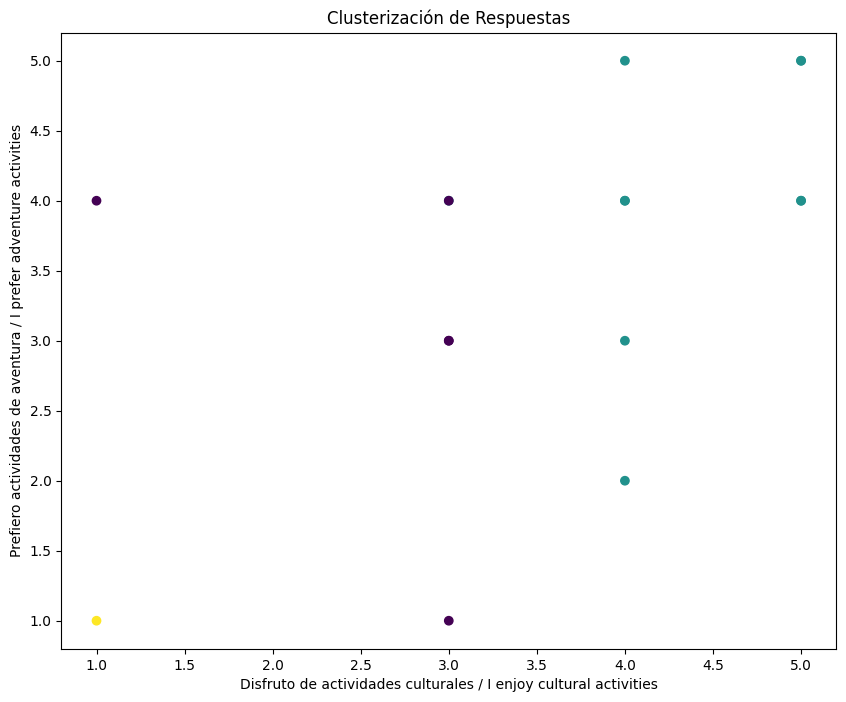

In [19]:
clustered_data = perform_clustering(data_clean)

In [49]:
def perform_anova(data, dependent_var, independent_vars):
    # Use patsy's quoting to handle special characters and spaces
    formula = f'Q("{dependent_var}") ~ ' + ' + '.join([f'C(Q("{var}"))' for var in independent_vars])
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table


anova_table = perform_anova(data_clean, '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?', ['Prefiero actividades de aventura / I prefer adventure activities', 'Disfruto de actividades culturales / I enjoy cultural activities', 'Me gusta relajarme durante mis viajes / I like to relax during my travels'])
print(anova_table)

                                                      sum_sq   df         F  \
C(Q("Prefiero actividades de aventura / I prefe...  1.116918  4.0  0.472542   
C(Q("Disfruto de actividades culturales / I enj...  8.845455  3.0  4.989744   
C(Q("Me gusta relajarme durante mis viajes / I ...  7.196048  4.0  3.044482   
Residual                                            2.954545  5.0       NaN   

                                                      PR(>F)  
C(Q("Prefiero actividades de aventura / I prefe...  0.756244  
C(Q("Disfruto de actividades culturales / I enj...  0.057881  
C(Q("Me gusta relajarme durante mis viajes / I ...  0.126719  
Residual                                                 NaN  


In [58]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Seleccionar las columnas relevantes para el análisis
data_anova = data[['Edad', '¿Qué tan dispuesto está a pagar por servicios adicionales dentro de la aplicación? / How willing are you to pay for additional services within the app?']]

# Renombrar columnas para facilitar el análisis
data_anova.columns = ['Edad', 'Dispuesto']

# Eliminar filas con valores nulos
data_anova = data_anova.dropna()

# Codificar la variable dependiente (Dispuesto) en una escala numérica
dispuesto_map = {
    'Nada dispuesto': 1,
    'Poco dispuesto': 2,
    'A veces dispuesto': 3,
    'Dispuesto': 4,
    'Muy dispuesto': 5
}
data_anova['Dispuesto'] = data_anova['Dispuesto'].map(dispuesto_map)

# Realizar el ANOVA
model = ols('Dispuesto ~ C(Edad)', data=data_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Interpretación automatizada
def interpretar_anova(anova_table):
    p_value = anova_table['PR(>F)'][0]
    if p_value < 0.05:
        return "Existen diferencias significativas en la disposición a pagar por servicios adicionales entre los diferentes grupos de edad (p < 0.05)."
    else:
        return "No existen diferencias significativas en la disposición a pagar por servicios adicionales entre los diferentes grupos de edad (p ≥ 0.05)."

# Obtener la interpretación
interpretacion = interpretar_anova(anova_table)

# Imprimir resultados
print("Tabla ANOVA:")
print(anova_table)
print("\nInterpretación:")
print(interpretacion)


Tabla ANOVA:
             sum_sq    df         F    PR(>F)
C(Edad)    0.983333   2.0  0.439752  0.654173
Residual  13.416667  12.0       NaN       NaN

Interpretación:
No existen diferencias significativas en la disposición a pagar por servicios adicionales entre los diferentes grupos de edad (p ≥ 0.05).


## ANÁLISIS DESCRIPTIVO

In [59]:
descripcion = data.describe(include='all')
print(descripcion)


                       Marca temporal                Edad    Género  \
count                              16                  15        16   
unique                            NaN                   3         2   
top                               NaN  Joven (18-25 años)  Femenino   
freq                              NaN                  12         9   
mean    2024-07-18 08:43:34.185437696                 NaN       NaN   
min        2024-07-17 20:24:23.422000                 NaN       NaN   
25%     2024-07-17 22:19:06.235500032                 NaN       NaN   
50%     2024-07-17 22:49:45.194000128                 NaN       NaN   
75%     2024-07-18 13:45:13.091000064                 NaN       NaN   
max        2024-07-19 17:15:49.095000                 NaN       NaN   

       ¿Con qué frecuencia utiliza tecnología en sus viajes? / How often do you use technology in your travels?  \
count                                                  16                                              

# CLUSTERING

## Análisis descriptivo

/usr/local/lib/python3.10/dist-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


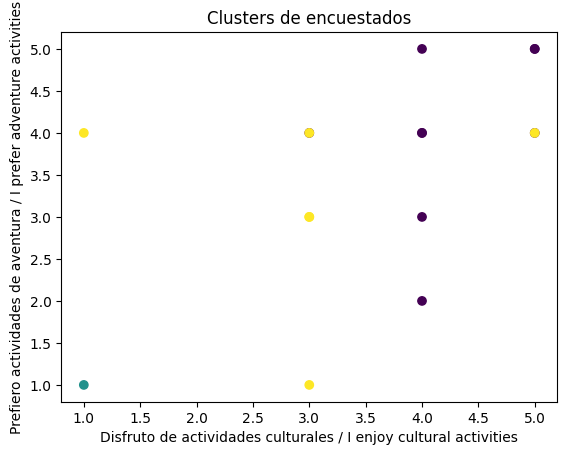

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                      OLS Regression Results                                                     
=================================================================================================================================
Dep. Variable:     Q("Disfruto de actividades culturales / I enjoy cultural activities")   R-squared:                       0.178
Model:                                                                               OLS   Adj. R-squared:                 -0.046
Method:                                                                    Least Squares   F-statistic:                    0.7960
Date:                                                                   Sat, 20 Jul 2024   Prob (F-statistic):              0.521
Time:                                                                           22:51:49   Log-Likelihood:                -23.252
No. Observations:                                                                     15   AIC:                             54.50
Df Residuals:                                                                         11   BIC:                             57.34
Df Model:                                                                              3                                         
Covariance Type:                                                               nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  3.7500      0.471      7.966      0.000       2.714       4.786
Edad[T.Mediana edad (26-40 años)]       4.441e-16      1.153   3.85e-16      1.000      -2.538       2.538
Edad[T.Muy joven (menores de 18 años)]     2.0000      1.489      1.344      0.206      -1.276       5.276
Género[T.Masculono]                       -0.7500      0.815     -0.920      0.377      -2.545       1.045
==============================================================================
Omnibus:                        4.456   Durbin-Watson:                   2.673
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                2.442
Skew:                          -0.978   Prob(JB):                        0.295
Kurtosis:                       3.280   Cond. No.                         5.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Análisis descriptivo
descriptive_stats = data_clean.describe()

# Calcular KMO y prueba de esfericidad de Bartlett
kmo_all, kmo_model = calculate_kmo(data_clean[columns_to_encode])
bartlett_chi_square, bartlett_p_value = calculate_bartlett_sphericity(data_clean[columns_to_encode])

# Realizar el Análisis Factorial Exploratorio
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(data_clean[columns_to_encode])

# Cargar los resultados
factor_loadings = fa.loadings_
factor_variance = fa.get_factor_variance()

# Análisis de Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
data_clean['cluster'] = kmeans.fit_predict(data_clean[columns_to_encode])

# Visualizar los clusters usando las primeras dos columnas codificadas
plt.scatter(data_clean[columns_to_encode[0]], data_clean[columns_to_encode[1]], c=data_clean['cluster'])
plt.xlabel(columns_to_encode[0])
plt.ylabel(columns_to_encode[1])
plt.title('Clusters de encuestados')
plt.show()

# Análisis de Regresión
model = ols('Q("Disfruto de actividades culturales / I enjoy cultural activities") ~ Edad + Género', data=data_clean).fit()
summary = model.summary()
summary


In [77]:
# Seleccionar solo las columnas numéricas para calcular las medias
numeric_columns = data_clean.select_dtypes(include=[np.number]).columns

# Calcular las medias de las variables para cada cluster
cluster_means = data_clean.groupby('cluster')[numeric_columns].mean()

# Visualizar las medias de las variables para cada cluster
cluster_means


,Disfruto de actividades culturales / I enjoy cultural activities,Prefiero actividades de aventura / I prefer adventure activities,Me gusta relajarme durante mis viajes / I like to relax during my travels,Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels,Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.,¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?,Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places,Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling,Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences,Gamificación y retos para ganar logros / Gamification and challenges to earn achievements,Guías personalizadas por personajes históricos / Personalized guides by historical characters,Rutas temáticas basadas en comida / Thematic routes based on food,Rutas temáticas basadas en emociones / Thematic routes based on emotions,Rutas temáticas basadas en cultura / Thematic routes based on culture,Rutas temáticas basadas en aventura / Thematic routes based on adventure,Rutas temáticas basadas en relajación / Thematic routes based on relaxation,Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends,cluster
cluster,,,,,,,,,,,,,,,,,,
0,4.222222,4.000000,4.111111,4.222222,4.325397,4.444444,4.444444,4.333333,4.222222,4.000000,4.222222,3.851852,3.555556,3.897436,3.888889,3.851852,3.750000,0.0
1,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,3.000000,2.000000,4.000000,1.000000,4.000000,3.642857,4.000000,3.846154,3.666667,4.000000,1.0
2,3.000000,3.166667,3.000000,3.844444,3.821429,3.500000,3.333333,2.500000,3.500000,2.666667,3.833333,3.333333,3.773810,3.333333,3.782051,3.388889,3.263889,2.0


from matplotlib import pyplot as plt
cluster_means['Disfruto de actividades culturales / I enjoy cultural activities'].plot(kind='hist', bins=20, title='Disfruto de actividades culturales / I enjoy cultural activities')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Prefiero actividades de aventura / I prefer adventure activities'].plot(kind='hist', bins=20, title='Prefiero actividades de aventura / I prefer adventure activities')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Me gusta relajarme durante mis viajes / I like to relax during my travels'].plot(kind='hist', bins=20, title='Me gusta relajarme durante mis viajes / I like to relax during my travels')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels'].plot(kind='hist', bins=20, title='Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means.plot(kind='scatter', x='Disfruto de actividades culturales / I enjoy cultural activities', y='Prefiero actividades de aventura / I prefer adventure activities', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means.plot(kind='scatter', x='Prefiero actividades de aventura / I prefer adventure activities', y='Me gusta relajarme durante mis viajes / I like to relax during my travels', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means.plot(kind='scatter', x='Me gusta relajarme durante mis viajes / I like to relax during my travels', y='Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cluster_means.plot(kind='scatter', x='Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels', y='Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rutas temáticas basadas en emociones / Thematic routes based on emotions']
  ys = series['Disfruto de actividades culturales / I enjoy cultural activities']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_means.sort_values('Rutas temáticas basadas en emociones / Thematic routes based on emotions', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rutas temáticas basadas en emociones / Thematic routes based on emotions')
_ = plt.ylabel('Disfruto de actividades culturales / I enjoy cultural activities')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rutas temáticas basadas en emociones / Thematic routes based on emotions']
  ys = series['Prefiero actividades de aventura / I prefer adventure activities']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_means.sort_values('Rutas temáticas basadas en emociones / Thematic routes based on emotions', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rutas temáticas basadas en emociones / Thematic routes based on emotions')
_ = plt.ylabel('Prefiero actividades de aventura / I prefer adventure activities')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rutas temáticas basadas en emociones / Thematic routes based on emotions']
  ys = series['Me gusta relajarme durante mis viajes / I like to relax during my travels']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_means.sort_values('Rutas temáticas basadas en emociones / Thematic routes based on emotions', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rutas temáticas basadas en emociones / Thematic routes based on emotions')
_ = plt.ylabel('Me gusta relajarme durante mis viajes / I like to relax during my travels')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rutas temáticas basadas en emociones / Thematic routes based on emotions']
  ys = series['Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cluster_means.sort_values('Rutas temáticas basadas en emociones / Thematic routes based on emotions', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rutas temáticas basadas en emociones / Thematic routes based on emotions')
_ = plt.ylabel('Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels')

from matplotlib import pyplot as plt
cluster_means['Disfruto de actividades culturales / I enjoy cultural activities'].plot(kind='line', figsize=(8, 4), title='Disfruto de actividades culturales / I enjoy cultural activities')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Prefiero actividades de aventura / I prefer adventure activities'].plot(kind='line', figsize=(8, 4), title='Prefiero actividades de aventura / I prefer adventure activities')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Me gusta relajarme durante mis viajes / I like to relax during my travels'].plot(kind='line', figsize=(8, 4), title='Me gusta relajarme durante mis viajes / I like to relax during my travels')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cluster_means['Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels'].plot(kind='line', figsize=(8, 4), title='Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


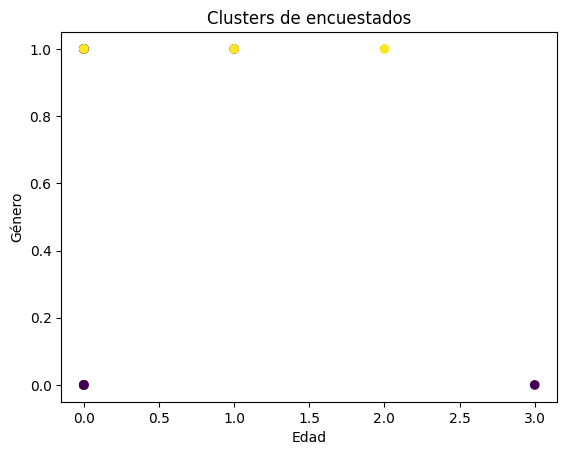

,Edad,Género,Disfruto de actividades culturales / I enjoy cultural activities,Prefiero actividades de aventura / I prefer adventure activities,Me gusta relajarme durante mis viajes / I like to relax during my travels,Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels,Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.,¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?,Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places,Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling,Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences,Gamificación y retos para ganar logros / Gamification and challenges to earn achievements,Guías personalizadas por personajes históricos / Personalized guides by historical characters,Rutas temáticas basadas en comida / Thematic routes based on food,Rutas temáticas basadas en emociones / Thematic routes based on emotions,Rutas temáticas basadas en cultura / Thematic routes based on culture,Rutas temáticas basadas en aventura / Thematic routes based on adventure,Rutas temáticas basadas en relajación / Thematic routes based on relaxation,Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends,cluster
cluster,,,,,,,,,,,,,,,,,,,,
0,0.444444,0.333333,4.222222,4.000000,4.111111,4.222222,4.325397,4.444444,4.444444,4.333333,4.222222,4.000000,4.222222,3.851852,3.555556,3.897436,3.888889,3.851852,3.750000,0.0
1,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,3.000000,2.000000,4.000000,1.000000,4.000000,3.642857,4.000000,3.846154,3.666667,4.000000,1.0
2,0.500000,0.500000,3.000000,3.166667,3.000000,3.844444,3.821429,3.500000,3.333333,2.500000,3.500000,2.666667,3.833333,3.333333,3.773810,3.333333,3.782051,3.388889,3.263889,2.0


In [78]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Codificar las variables de edad y género
le = LabelEncoder()
data['Edad'] = le.fit_transform(data['Edad'])
data['Género'] = le.fit_transform(data['Género'])

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Incluir edad y género en las columnas para clusterización
columns_to_cluster = columns_to_encode + ['Edad', 'Género']

# Análisis de Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
data_clean['cluster'] = kmeans.fit_predict(data_clean[columns_to_cluster])

# Visualizar los clusters usando las primeras dos columnas codificadas y edad y género
plt.scatter(data_clean['Edad'], data_clean['Género'], c=data_clean['cluster'])
plt.xlabel('Edad')
plt.ylabel('Género')
plt.title('Clusters de encuestados')
plt.show()

# Seleccionar solo las columnas numéricas para calcular las medias
numeric_columns = data_clean.select_dtypes(include=[np.number]).columns

# Calcular las medias de las variables para cada cluster
cluster_means = data_clean.groupby('cluster')[numeric_columns].mean()

# Visualizar las medias de las variables para cada cluster
cluster_means


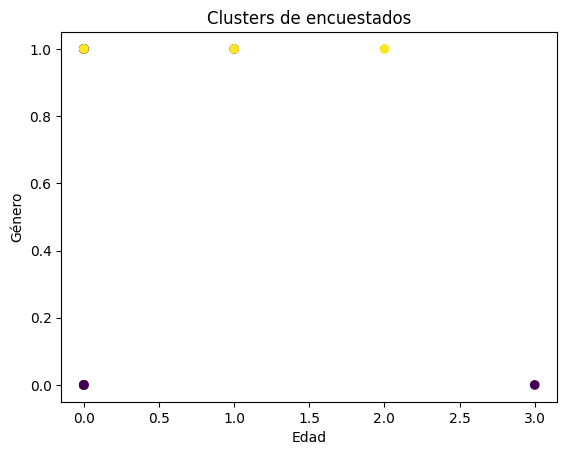

In [79]:
plt.scatter(data_clean['Edad'], data_clean['Género'], c=data_clean['cluster'])
plt.xlabel('Edad')
plt.ylabel('Género')
plt.title('Clusters de encuestados')
plt.show()


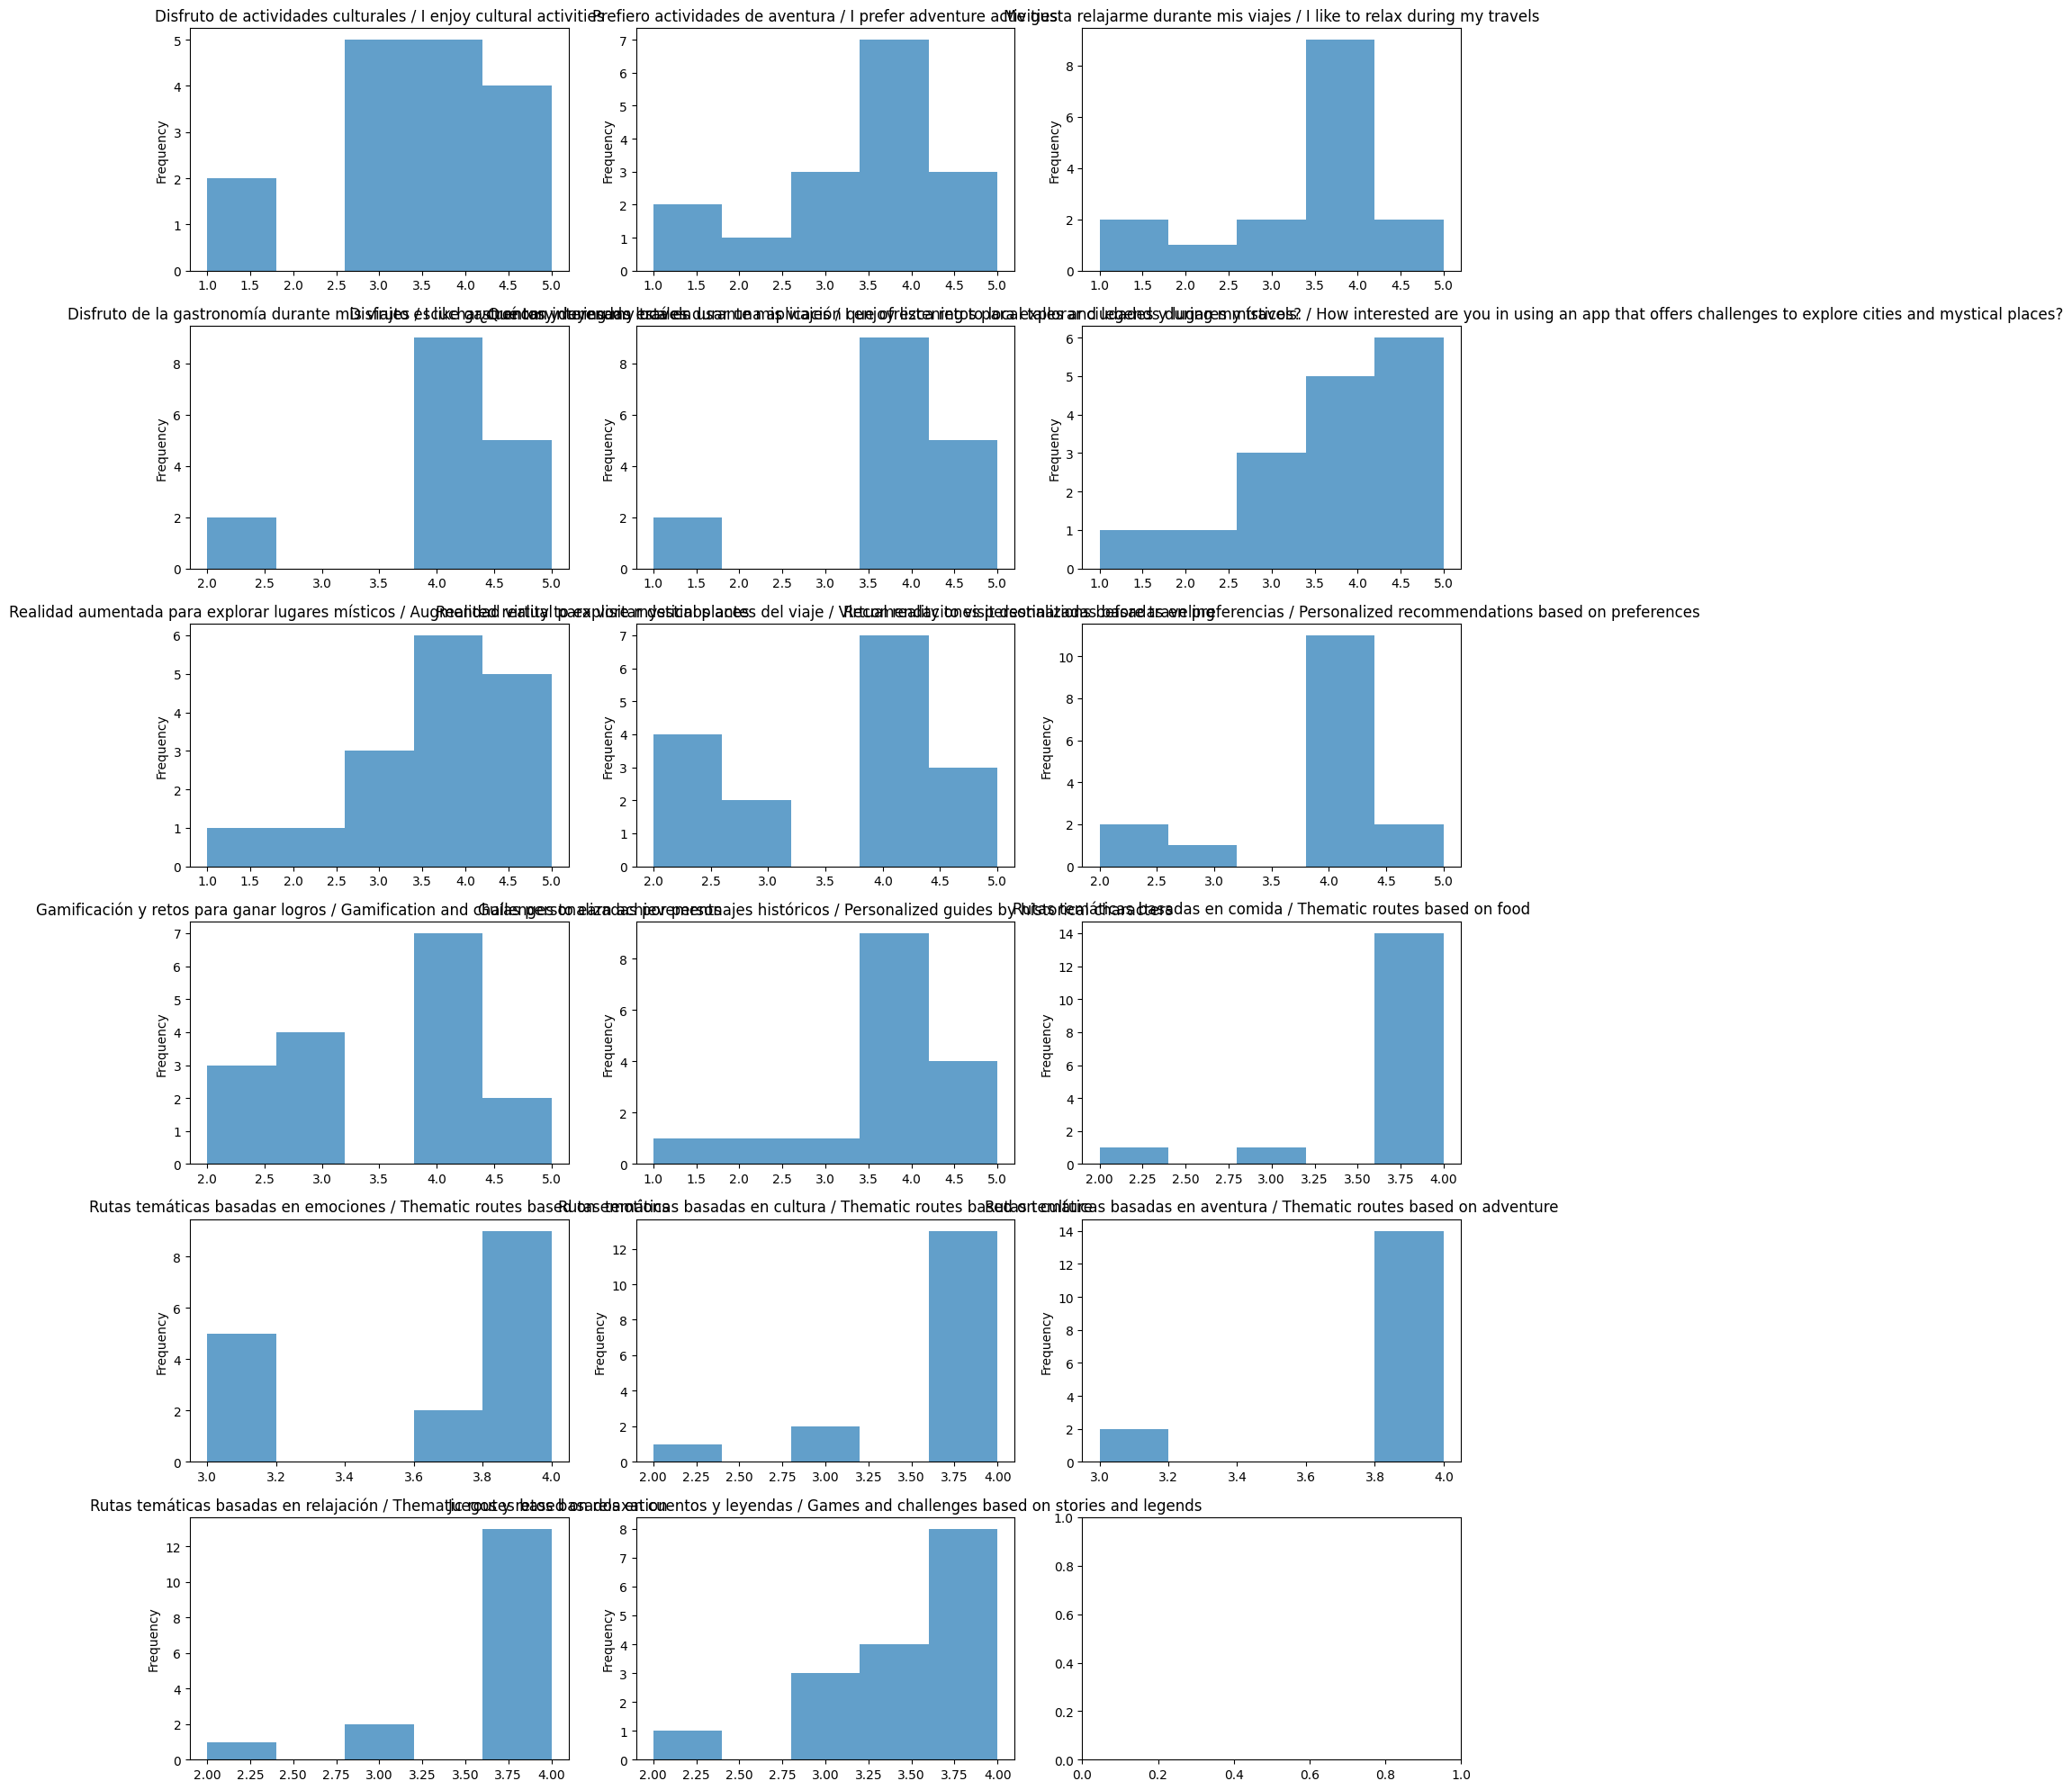

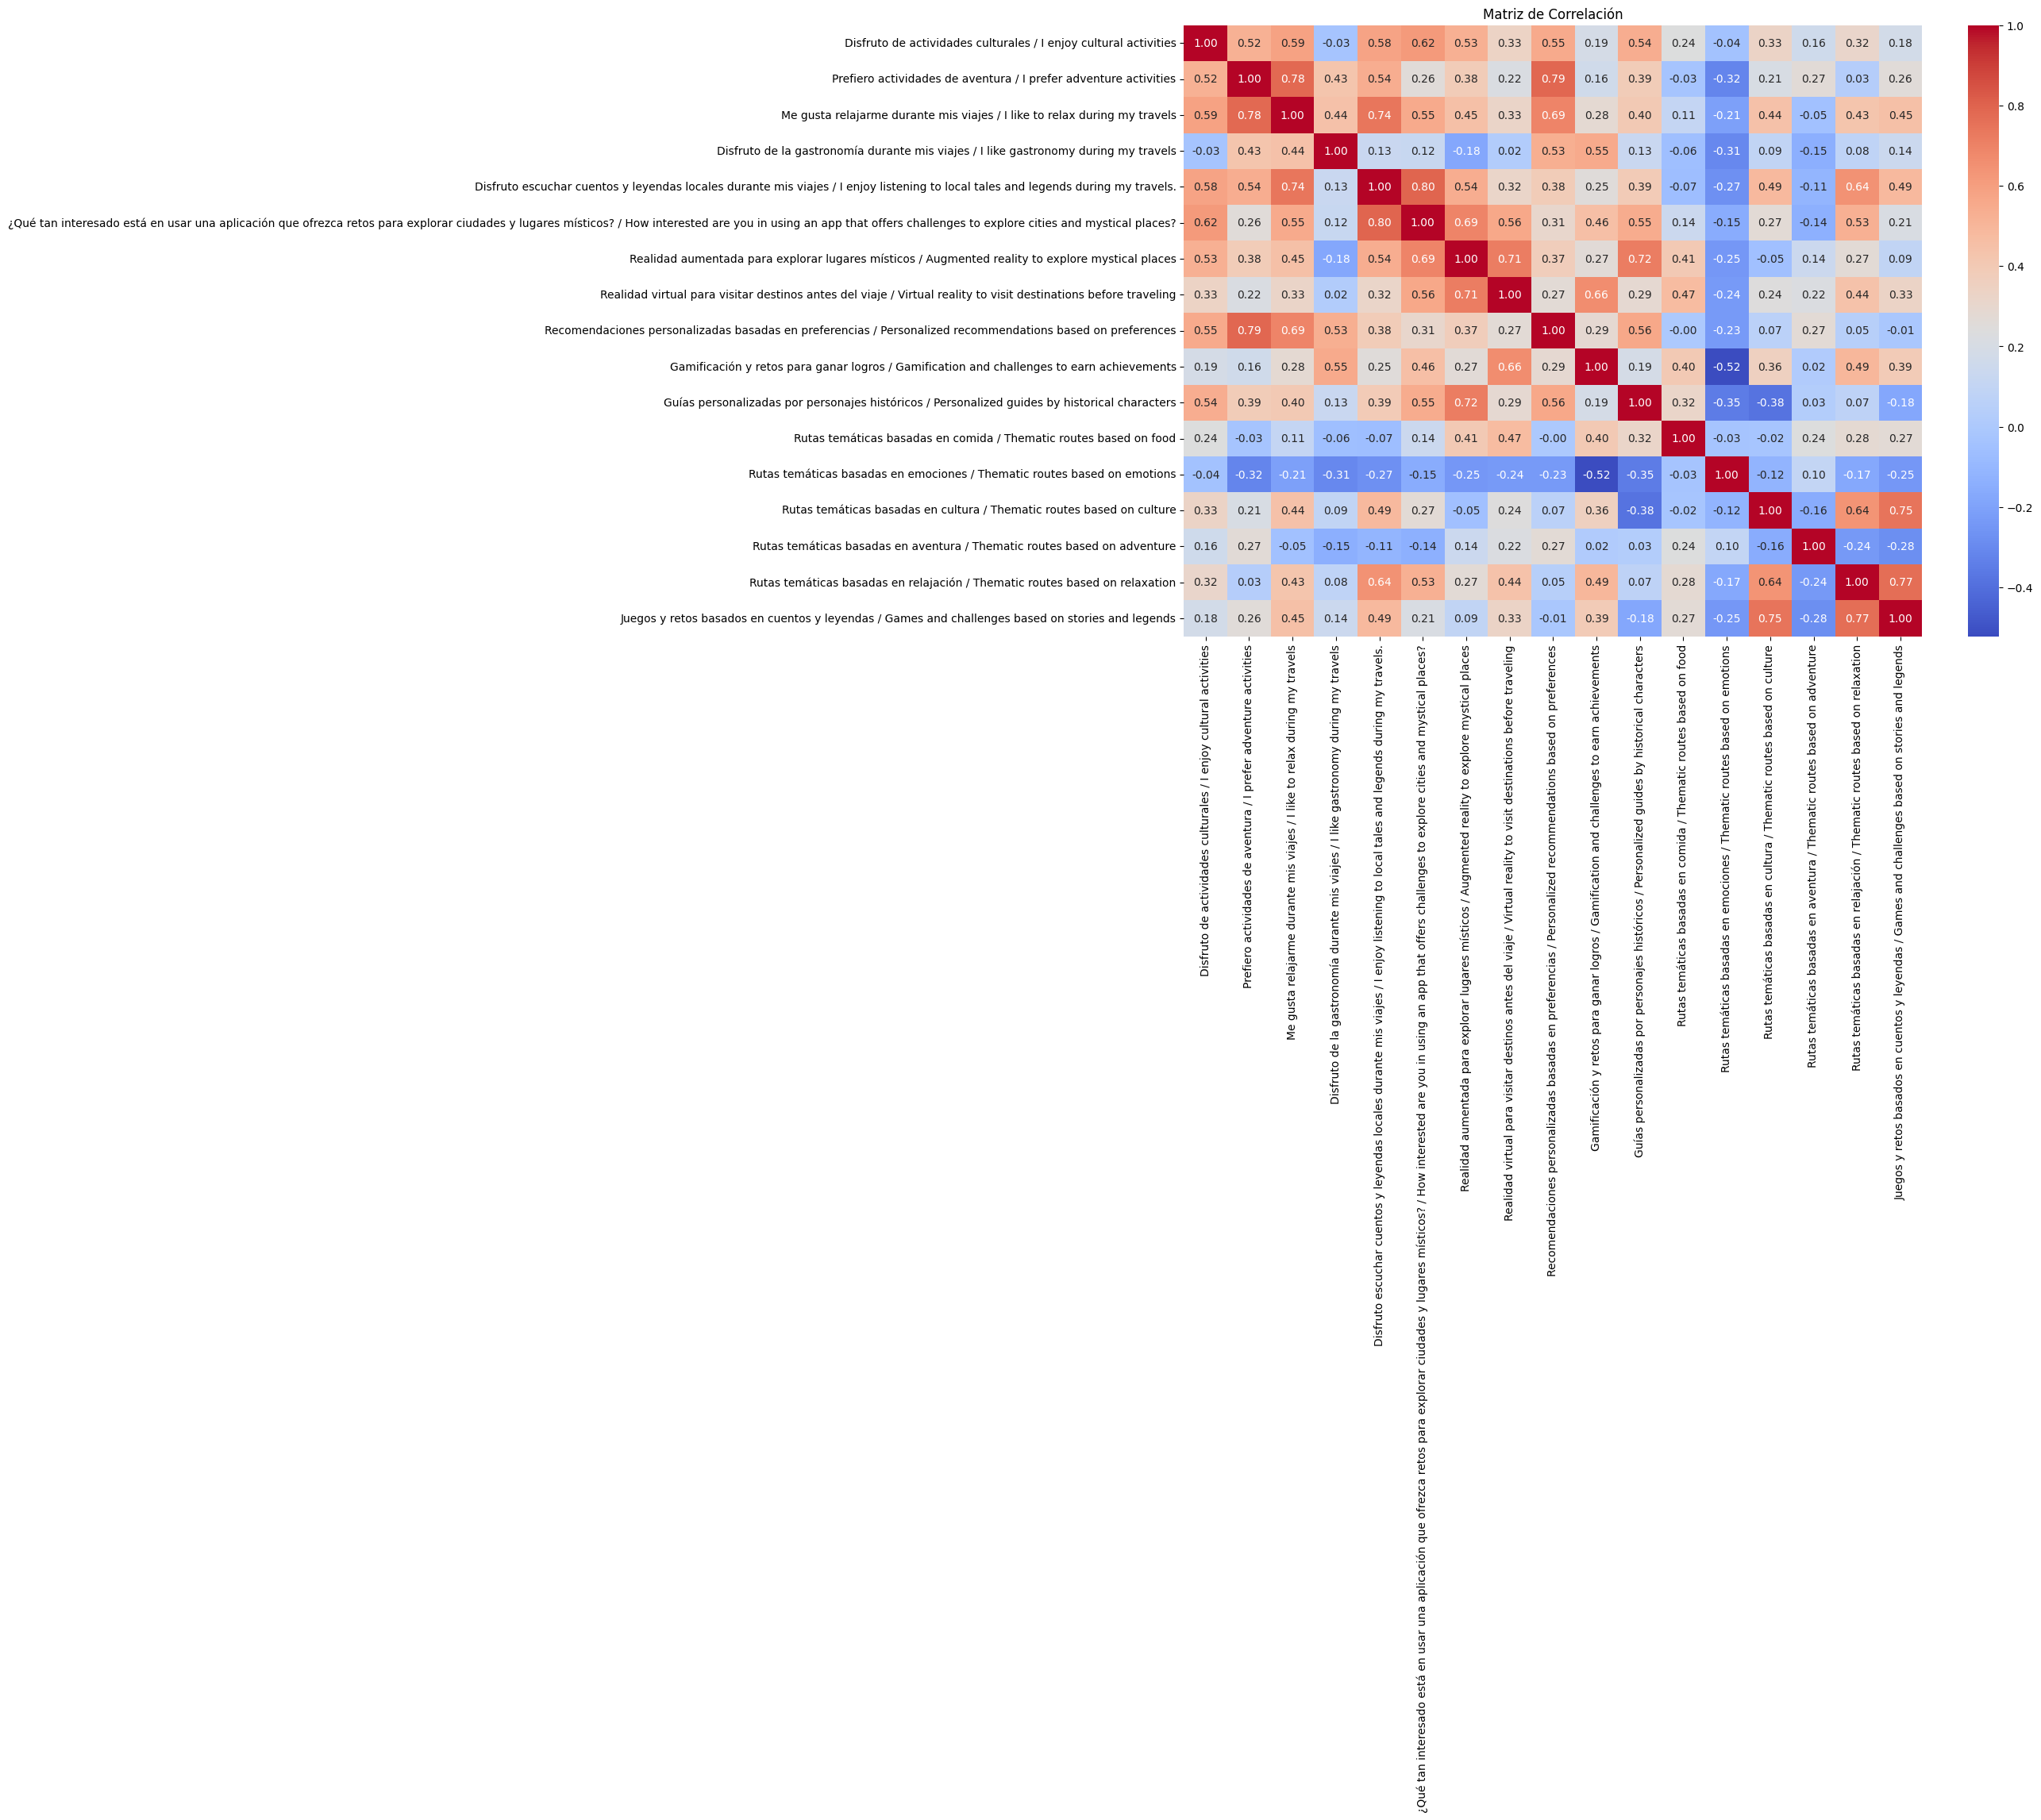

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Codificar las variables de edad y género
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Edad'] = le.fit_transform(data['Edad'])
data['Género'] = le.fit_transform(data['Género'])

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Crear histogramas
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
axes = axes.flatten()
for idx, col in enumerate(columns_to_encode):
    data_clean[col].plot(kind='hist', bins=5, ax=axes[idx], alpha=0.7, title=col)
plt.tight_layout()
plt.show()

# Crear matriz de correlación
correlation_matrix = data_clean[columns_to_encode].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


Chi-cuadrado: 1.168253968253968, p-valor: 0.7606279511324182
ANOVA F: 0.5595238095238095, p-valor: 0.6517829509422218


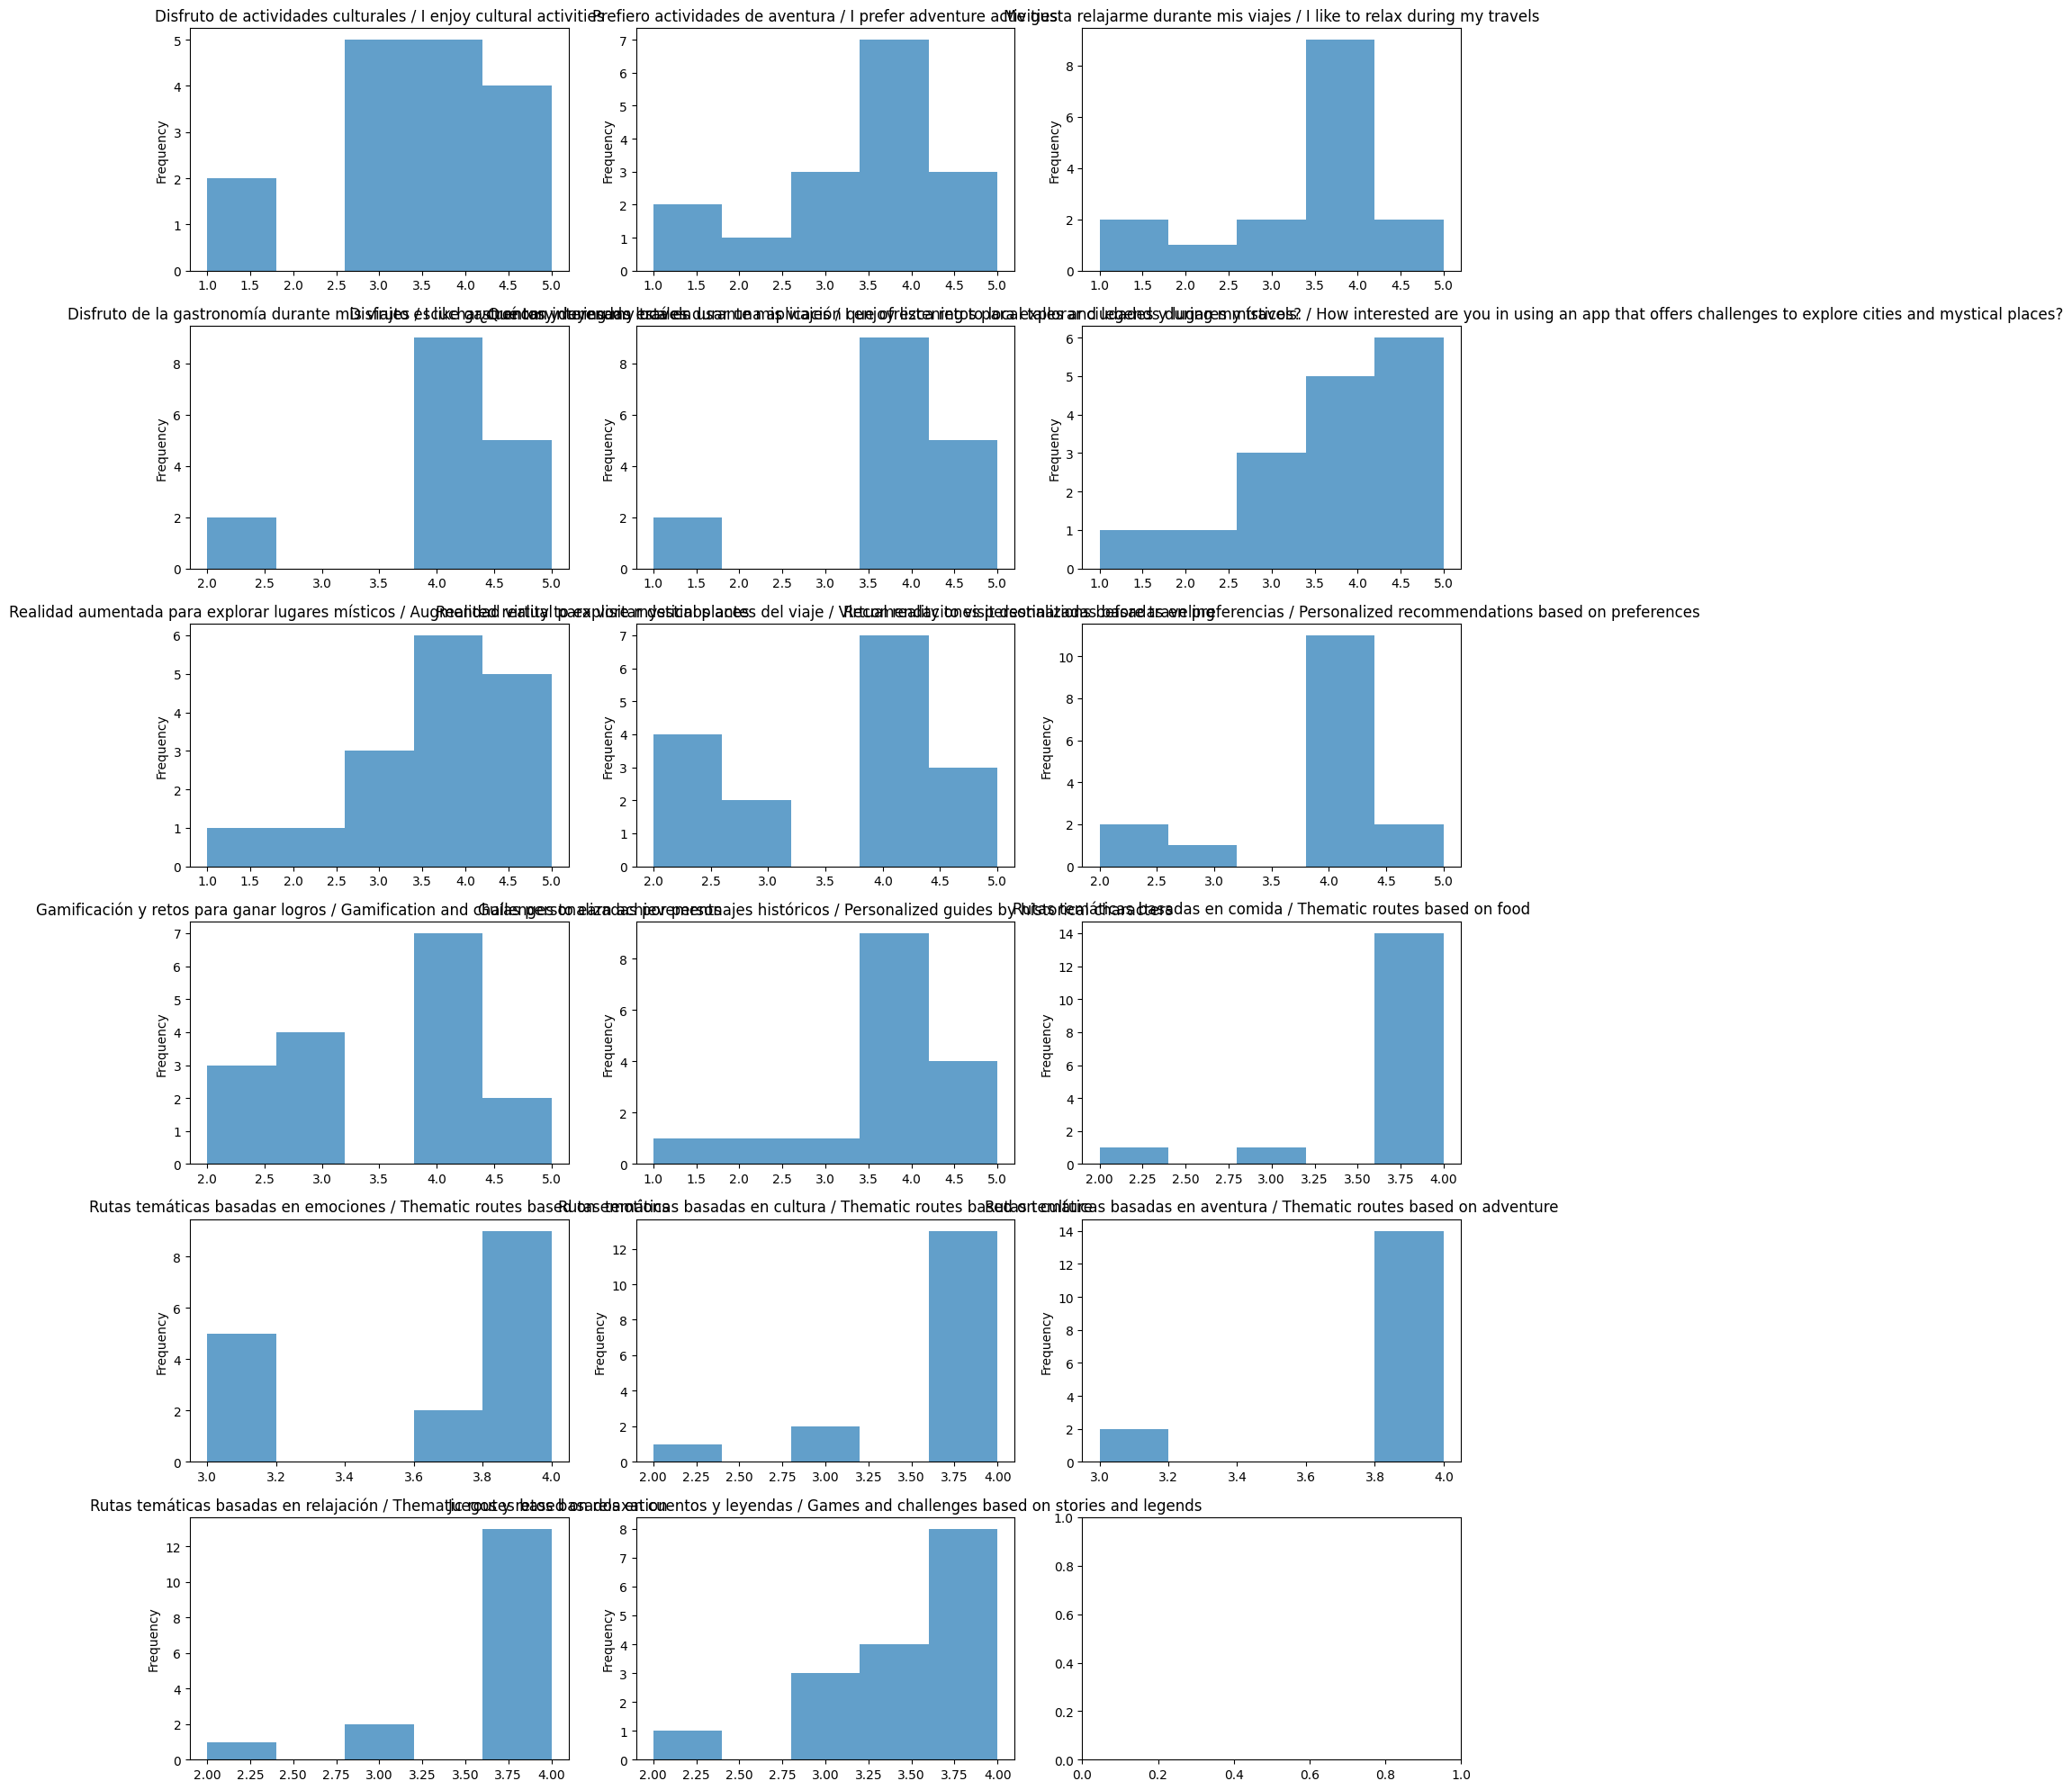

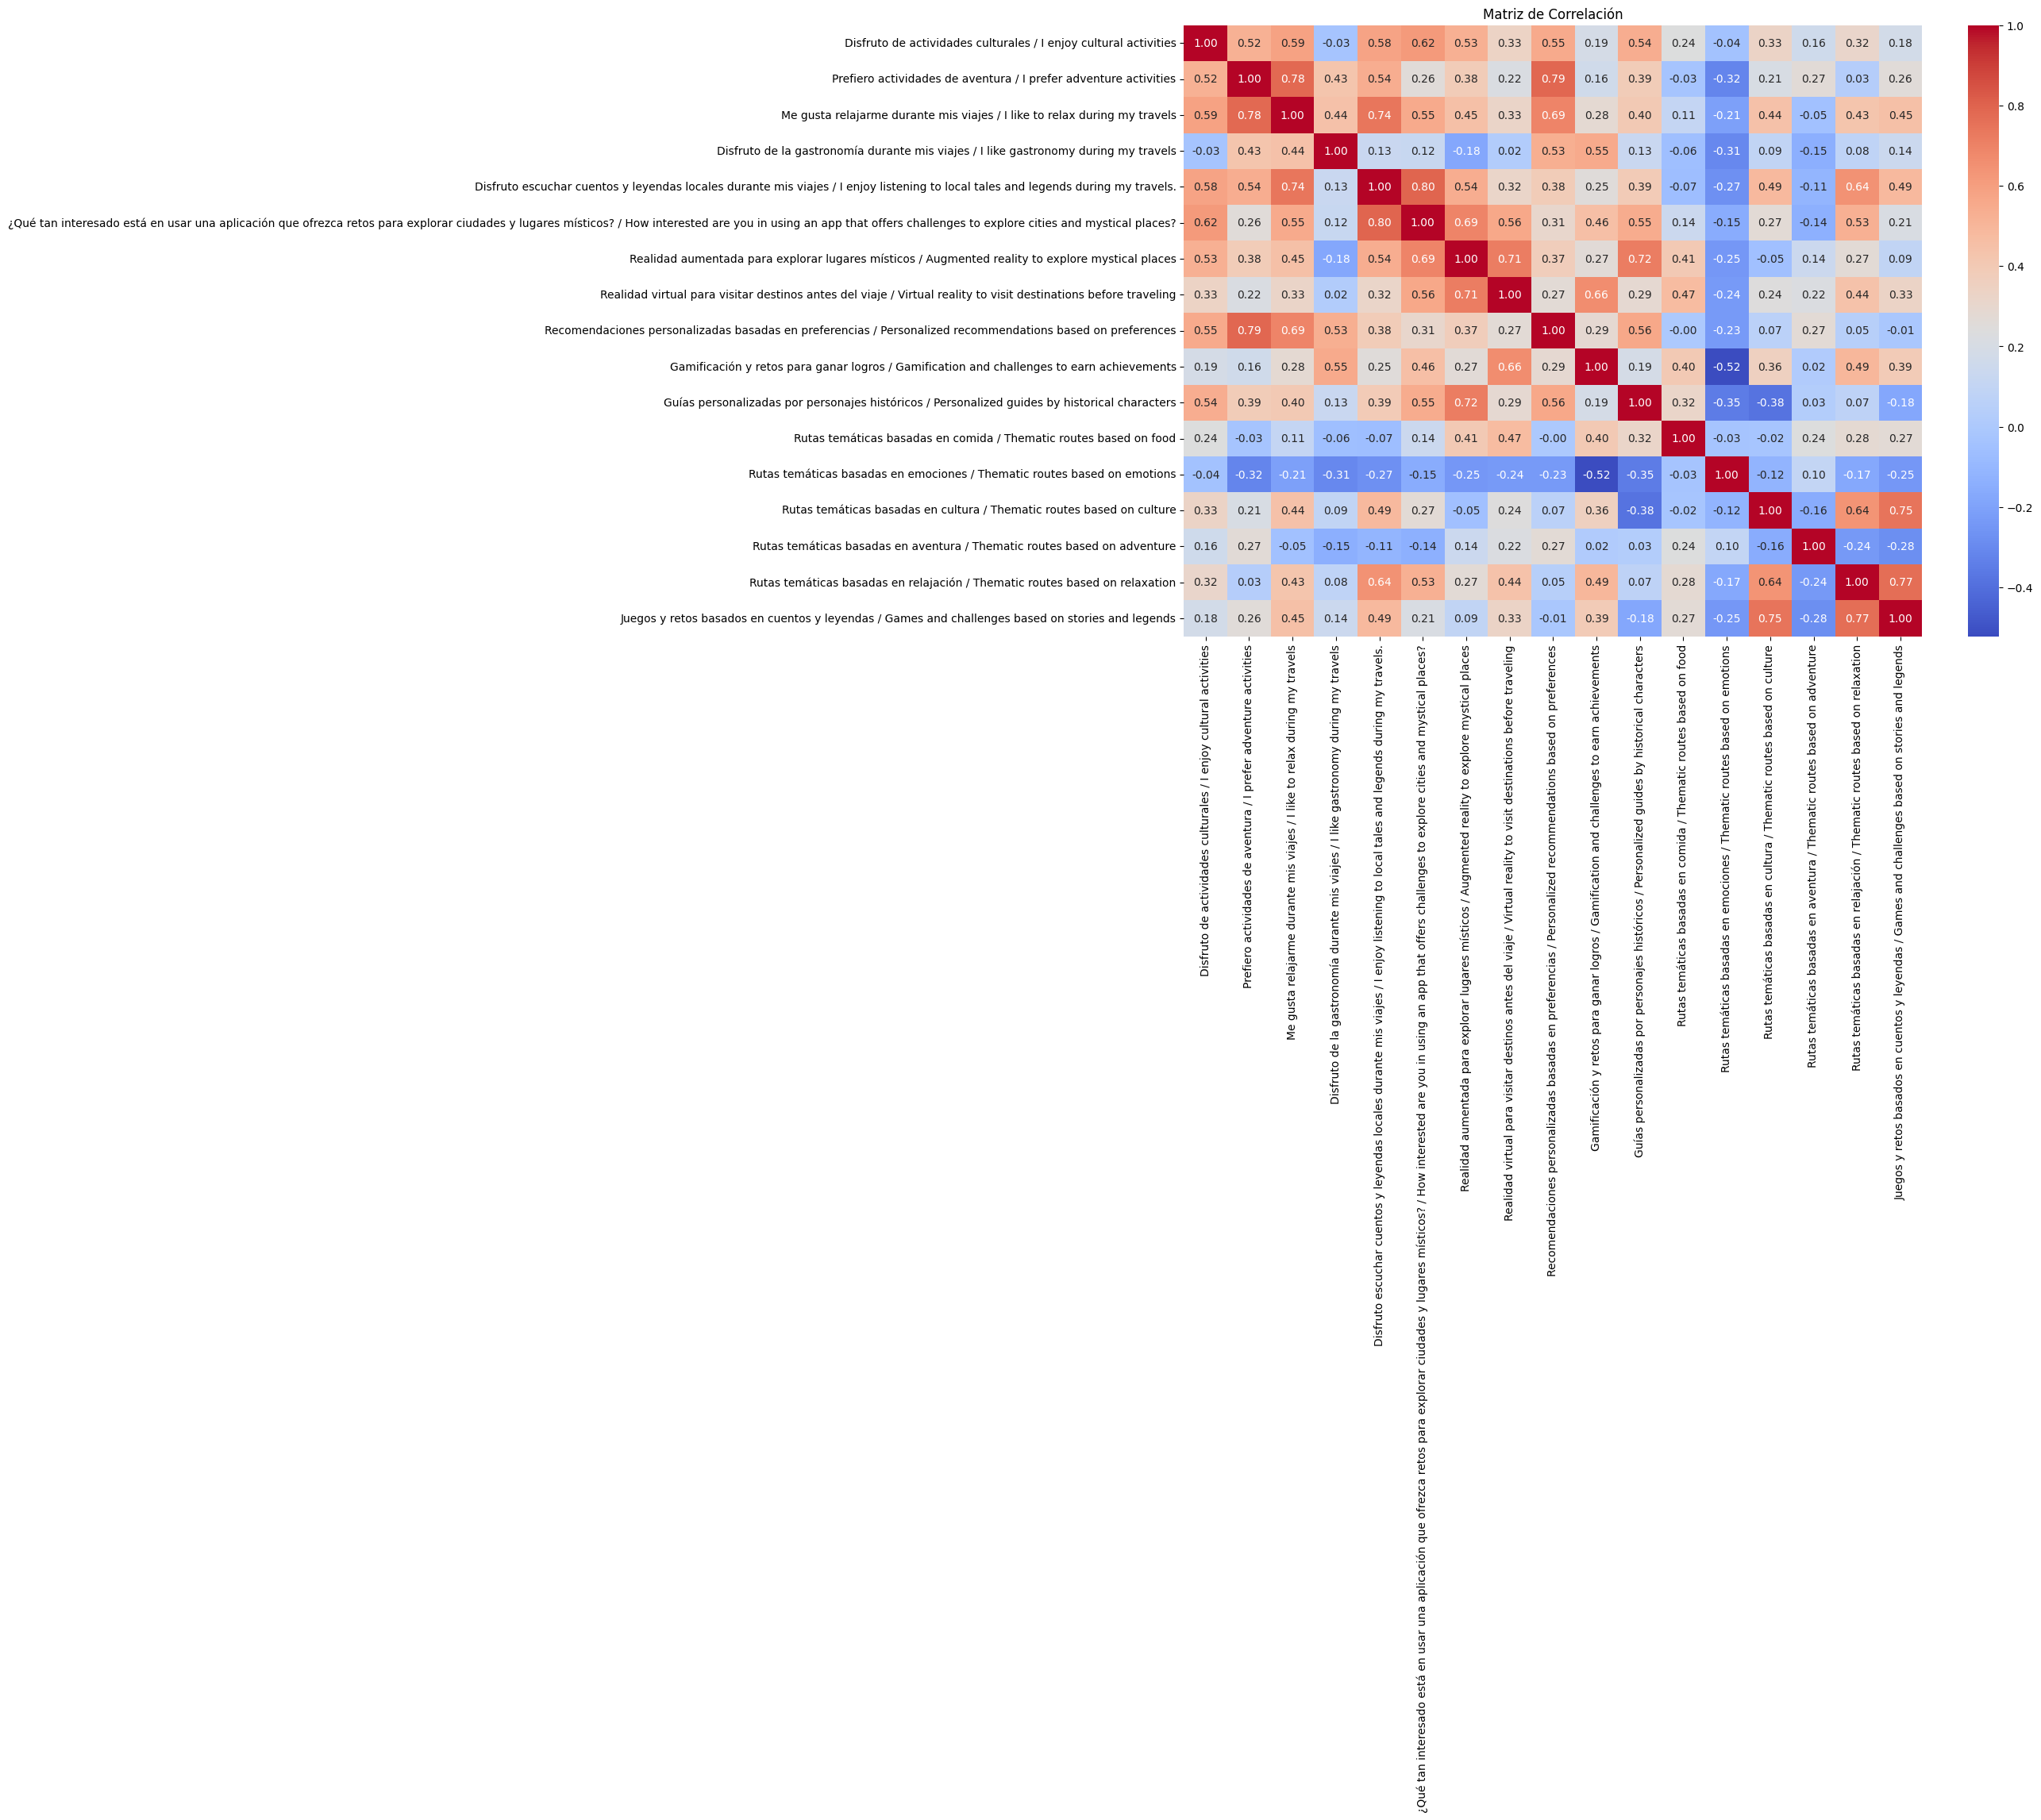

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, f_oneway

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Codificar las variables de edad y género
le = LabelEncoder()
data['Edad'] = le.fit_transform(data['Edad'])
data['Género'] = le.fit_transform(data['Género'])

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Prueba Chi-cuadrado para la variable 'Género' y 'Disfruto de actividades culturales'
contingency_table = pd.crosstab(data_clean['Género'], data_clean['Disfruto de actividades culturales / I enjoy cultural activities'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-cuadrado: {chi2}, p-valor: {p}')

# ANOVA para 'Disfruto de actividades culturales' y 'Edad'
anova_result = f_oneway(
    data_clean[data_clean['Edad'] == 0]['Disfruto de actividades culturales / I enjoy cultural activities'],
    data_clean[data_clean['Edad'] == 1]['Disfruto de actividades culturales / I enjoy cultural activities'],
    data_clean[data_clean['Edad'] == 2]['Disfruto de actividades culturales / I enjoy cultural activities'],
    data_clean[data_clean['Edad'] == 3]['Disfruto de actividades culturales / I enjoy cultural activities']
)
print(f'ANOVA F: {anova_result.statistic}, p-valor: {anova_result.pvalue}')

# Crear histogramas
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))
axes = axes.flatten()
for idx, col in enumerate(columns_to_encode):
    data_clean[col].plot(kind='hist', bins=5, ax=axes[idx], alpha=0.7, title=col)
plt.tight_layout()
plt.show()

# Crear matriz de correlación
correlation_matrix = data_clean[columns_to_encode].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Codificar las variables de edad y género
le = LabelEncoder()
data['Edad'] = le.fit_transform(data['Edad'])
data['Género'] = le.fit_transform(data['Género'])

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Prueba Chi-cuadrado para la variable 'Edad' y '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos?'
contingency_table = pd.crosstab(data_clean['Edad'], data_clean['¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-cuadrado: {chi2}, p-valor: {p}')

# Otras pruebas Chi-cuadrado recomendadas
# 1. Género vs. Prefiero actividades de aventura
contingency_table1 = pd.crosstab(data_clean['Género'], data_clean['Prefiero actividades de aventura / I prefer adventure activities'])
chi2_1, p_1, dof_1, ex_1 = chi2_contingency(contingency_table1)
print(f'Género vs. Prefiero actividades de aventura - Chi-cuadrado: {chi2_1}, p-valor: {p_1}')

# 2. Edad vs. Realidad aumentada para explorar lugares místicos
contingency_table2 = pd.crosstab(data_clean['Edad'], data_clean['Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places'])
chi2_2, p_2, dof_2, ex_2 = chi2_contingency(contingency_table2)
print(f'Edad vs. Realidad aumentada para explorar lugares místicos - Chi-cuadrado: {chi2_2}, p-valor: {p_2}')

# 3. Género vs. Gamificación y retos para ganar logros
contingency_table3 = pd.crosstab(data_clean['Género'], data_clean['Gamificación y retos para ganar logros / Gamification and challenges to earn achievements'])
chi2_3, p_3, dof_3, ex_3 = chi2_contingency(contingency_table3)
print(f'Género vs. Gamificación y retos para ganar logros - Chi-cuadrado: {chi2_3}, p-valor: {p_3}')


Chi-cuadrado: 8.177777777777777, p-valor: 0.7710878694367677
Género vs. Prefiero actividades de aventura - Chi-cuadrado: 6.325018896447467, p-valor: 0.17615494127385978
Edad vs. Realidad aumentada para explorar lugares místicos - Chi-cuadrado: 14.799999999999999, p-valor: 0.2525565714997028
Género vs. Gamificación y retos para ganar logros - Chi-cuadrado: 0.22978080120937264, p-valor: 0.9726442354639223


In [ ]:
Chi-cuadrado: 1.168253968253968, p-valor: 0.7606279511324182
ANOVA F: 0.5595238095238095, p-valor: 0.6517829509422218

Chi-cuadrado: 8.177777777777777, p-valor: 0.7710878694367677
Género vs. Prefiero actividades de aventura - Chi-cuadrado: 6.325018896447467, p-valor: 0.17615494127385978
Edad vs. Realidad aumentada para explorar lugares místicos - Chi-cuadrado: 14.799999999999999, p-valor: 0.2525565714997028
Género vs. Gamificación y retos para ganar logros - Chi-cuadrado: 0.22978080120937264, p-valor: 0.9726442354639223

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Cargar el archivo Excel
file_path = 'Encuesta.xlsx'
data = pd.read_excel(file_path)

# Codificar las variables de edad y género
le = LabelEncoder()
data['Edad'] = le.fit_transform(data['Edad'])
data['Género'] = le.fit_transform(data['Género'])

# Columnas a codificar
columns_to_encode = [
    'Disfruto de actividades culturales / I enjoy cultural activities',
    'Prefiero actividades de aventura / I prefer adventure activities',
    'Me gusta relajarme durante mis viajes / I like to relax during my travels',
    'Disfruto de la gastronomía durante mis viajes / I like gastronomy during my travels',
    'Disfruto escuchar cuentos y leyendas locales durante mis viajes / I enjoy listening to local tales and legends during my travels.',
    '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?',
    'Realidad aumentada para explorar lugares místicos / Augmented reality to explore mystical places',
    'Realidad virtual para visitar destinos antes del viaje / Virtual reality to visit destinations before traveling',
    'Recomendaciones personalizadas basadas en preferencias / Personalized recommendations based on preferences',
    'Gamificación y retos para ganar logros / Gamification and challenges to earn achievements',
    'Guías personalizadas por personajes históricos / Personalized guides by historical characters',
    'Rutas temáticas basadas en comida / Thematic routes based on food',
    'Rutas temáticas basadas en emociones / Thematic routes based on emotions',
    'Rutas temáticas basadas en cultura / Thematic routes based on culture',
    'Rutas temáticas basadas en aventura / Thematic routes based on adventure',
    'Rutas temáticas basadas en relajación / Thematic routes based on relaxation',
    'Juegos y retos basados en cuentos y leyendas / Games and challenges based on stories and legends'
]

# Mapeo de respuestas a valores numéricos
response_mapping = {
    'Totalmente de acuerdo': 5,
    'De acuerdo': 4,
    'Ni de acuerdo ni en desacuerdo (Neutral)': 3,
    'En desacuerdo': 2,
    'Totalmente en desacuerdo': 1,
    'Muy útil': 5,
    'Útil': 4,
    'Neutral': 3,
    'Poco útil': 2,
    'Nada útil': 1,
    'Muy interesado': 5,
    'Interesado': 4,
    'A veces': 3,
    'Poco interesado': 2,
    'Nada interesado': 1,
    'Muy dispuesto': 5,
    'Dispuesto': 4,
    'A veces dispuesto': 3,
    'Poco dispuesto': 2,
    'Nada dispuesto': 1
}

# Aplicar el mapeo y manejar valores NaN e infinitos
for col in columns_to_encode:
    data[col] = data[col].map(response_mapping)
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mean(), inplace=True)
    if np.isinf(data[col]).sum() > 0:
        data[col].replace([np.inf, -np.inf], data[col].mean(), inplace=True)

data_clean = data.dropna(subset=columns_to_encode)

# Definir la variable dependiente y las variables independientes
dependent_var = '¿Qué tan interesado está en usar una aplicación que ofrezca retos para explorar ciudades y lugares místicos? / How interested are you in using an app that offers challenges to explore cities and mystical places?'
independent_vars = columns_to_encode[:columns_to_encode.index(dependent_var)] + ['Edad', 'Género']

# Crear la fórmula para el ANOVA
formula = f'Q("{dependent_var}") ~ ' + ' + '.join([f'Q("{var}")' for var in independent_vars])

# Realizar el ANOVA
model = ols(formula, data=data_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Mostrar la tabla ANOVA
print(anova_table)


                                                      sum_sq   df         F  \
Q("Disfruto de actividades culturales / I enjoy...  2.244744  1.0  4.038374   
Q("Prefiero actividades de aventura / I prefer ...  1.455444  1.0  2.618394   
Q("Me gusta relajarme durante mis viajes / I li...  0.097428  1.0  0.175276   
Q("Disfruto de la gastronomía durante mis viaje...  1.004381  1.0  1.806917   
Q("Disfruto escuchar cuentos y leyendas locales...  5.247665  1.0  9.440733   
Q("Edad")                                           0.010215  1.0  0.018377   
Q("Género")                                         0.195674  1.0  0.352024   
Residual                                            4.446828  8.0       NaN   

                                                      PR(>F)  
Q("Disfruto de actividades culturales / I enjoy...  0.079331  
Q("Prefiero actividades de aventura / I prefer ...  0.144292  
Q("Me gusta relajarme durante mis viajes / I li...  0.686479  
Q("Disfruto de la gastronomía durant